# Sentence-Level PCA
Last semester I looked at the trends over time by featurizing each decade based on the word frequencies. Now, I'm trying the to spot similar trends but by featurizing based on sentence structure. 

In [1]:
import spacy
import os
import xml.etree.ElementTree as ET
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from spacy import displacy
import scipy.stats
import pandas as pd
import re
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
from spacy.tokens import Doc

# Tokenize only on whitespace to compare spacy tagger with sparv's tags
class WhitespaceTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(" ")
        return Doc(self.vocab, words=words)

nlp = spacy.load(os.path.join("..", "sv_model_upos", "sv_model0", "sv_model_upos0-0.0.0"))
#nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

## Building Sentence-Level Features

In [3]:
# Look at distribution of sentence lengths across languages/times
"""
    Given a path to a .xml file containing a decade of Swedish newspaper publications, builds a dataframe where each row 
    is a sentence in the publication and the columns are the length of the sentence, the depth of the sentence's parse
    tree, the number of leaves, and the count of a variety of dependency relations present in the sentence. 
"""
def traverseSwed(filepath):
    parser = ET.iterparse(file_path, events=('start','end'))
    parser = iter(parser)
    event, root = next(parser)
    df = pd.DataFrame(columns=("length", "depth", "leaves", "amod", "nmod", "nsubj", "dobj", "iobj"))
    
    words = ""
    pos = []
    sum_overlaps= 0 
    num_para = 0
    i = 0
    ag = []
    row = {}
    for event, elem in parser:
        if elem.tag == "w":
            if event == "end":
                words +=  elem.text + " "
                elem.clear()
            root.clear()
        if elem.tag == "sentence" and event=="end":
            words = words.strip()
            if len(words) == 0: continue
            doc = nlp(words)
            tok = list(doc.sents)[0].root
            row.update({
                "length": len(doc),
                "depth": treeDepth(tok),
                "leaves": numLeafs(tok), 
            })
            row.update(numComponents(tok))
            words = ""
            i += 1
            df = df.append(pd.Series(row), ignore_index=True)
        # Take only the first 10,000 sentences if in a time crunch
        if i == 10000: break
    return df
            

"""
    For a sentence with the root token tok, returns the depth of the token's subtree. 
"""
def treeDepth(tok):
    if len(list(tok.children)) == 0: return 0 
    
    depths = np.array([treeDepth(c) for c in tok.children]).flatten()
    return max(depths) + 1

"""
    For a sentence with the root token tok, returns the number of leaves in the token's subtree. 
"""
def numLeafs(tok): 
    if len(list(tok.children)) == 0: return 1
    
    leafs = np.array([numLeafs(c) for c in tok.children]).flatten()
    return sum(leafs)

"""
    For a sentence with the root token tok, returns the breakdown on the dependency relations
    returns a tuple of ("amod", "nmod", "nsubj", "dobj", "iobj")
    An explanation of these relations can be found at https://spacy.io/usage/linguistic-features#dependency-parse
"""
def numComponents(tok): 
    c = Counter({"amod":0, "nmod":0, "nsubj":0, "dobj":0, "iobj":0})
    for token in tok.children: 
        if token.dep_ in c.keys():
            c[token.dep_] += 1
    return c

In [ ]:
df_swed = pd.DataFrame(columns=("decade", "length", "depth", "leaves", "amod", "nmod", "nsubj", "dobj", "iobj"))
data_dir = os.path.join("/share/magpie/datasets/Swedish", "kubhist2")
for xml in os.listdir(data_dir):
    if xml.endswith(".xml"):
        decade = int(re.findall(r'\d{4}', xml)[0])
        file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2",xml)
        df = traverseSwed(file_path)
        means = df.mean(axis=0)
        means["decade"] = decade
        means.name = xml
        print(xml)
        df_swed = df_swed.append(means)
        del df
        del means

In [3]:
with open("swedFeats.pickle", 'rb') as f: 
    feats =  pickle.load(f)
# Drop outlier newspaper
feats = feats.drop("kubhist2-aftonbladet-1830.xml", axis=0) 
# Dobj ended up being all 0's so drop
feats = feats.drop("dobj", axis=1)

In [4]:
c = Counter()
for name in feats.index:
    decade = int(re.findall(r'\d{4}', name)[0])
    c[decade] += 1
print(c)

Counter({1830: 4, 1780: 3, 1810: 3, 1820: 3, 1840: 3, 1850: 3, 1860: 3, 1870: 3, 1770: 2, 1790: 2, 1800: 2, 1890: 2, 1880: 2, 1750: 1, 1760: 1})


## PCA of Sentence-Level Feature Vectors

In [5]:
decade_group = feats.groupby("decade").mean()
scaler = StandardScaler()
decade_group= scaler.fit_transform(decade_group)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(decade_group)

PCA works by finding the axes along which the data varies the most. It creates these axes as a linear combination of the original feature vectors. We can use this fact to get an idea of how important each original feature is to explaining the variance in the data. 

Looking at the coefficients for the features that make up the first Principal Component, or the axis along which the data varies the most, we can make a few observations. First, we see that sentence length and the number of leaves are the top two features in determining the variance between decades. The next most important features are the number of subject nodes, the number of indirect objects in a sentence, and the depth of the parse tree. Less important are the number of adjectival modifiers and the number of nominal modifiers. 

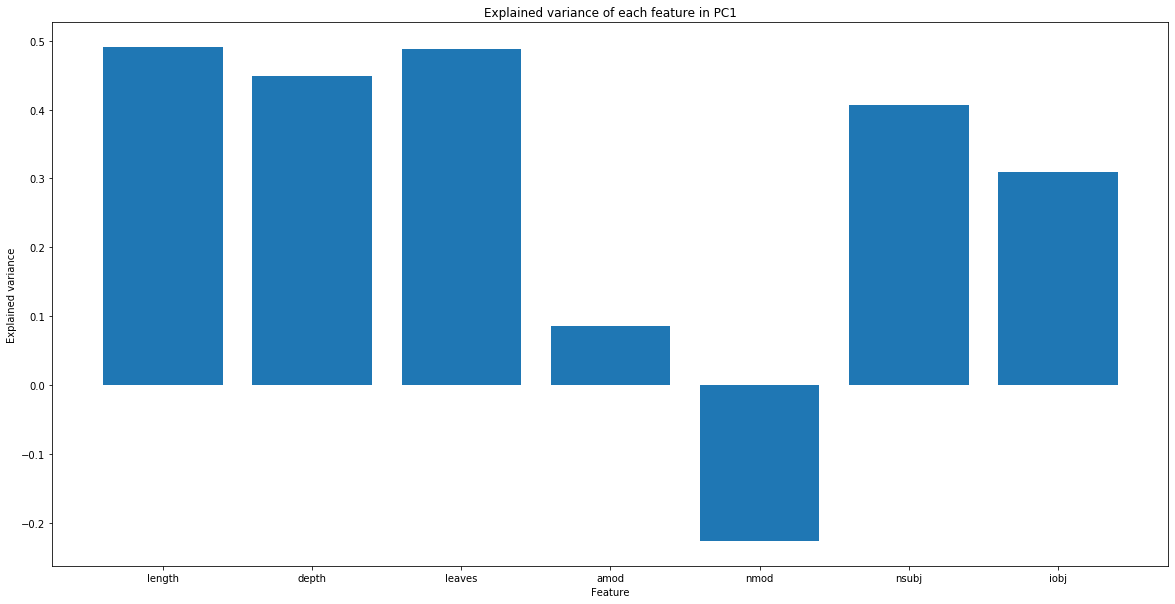

In [9]:
plt.bar(feats.columns[1:], pca.components_[0])
plt.xlabel("Feature")
plt.ylabel("Explained variance")
plt.title("Explained variance of each feature in PC1")
plt.show()

Projecting the decade feature vectors onto 2 Principal Components we can try to look for any patterns in the relationship between decades. The latest decades (eg. 1880 and 1890) seem to be relatively separate from the rest of the decades, perhaps indicating a change in writing style. Not too surprisingly, the earliest decade (1750) seems to be separate from the rest of the decades. It's not uncommon for earlier writing to appear different, if anything because the OCR systems used to read in the newspapers publications may not work as well on earlier versions of the newspaper. There are a few other loose clustering of decades, but none are quite as compelling as when we featurized each decade using word frequencies. 

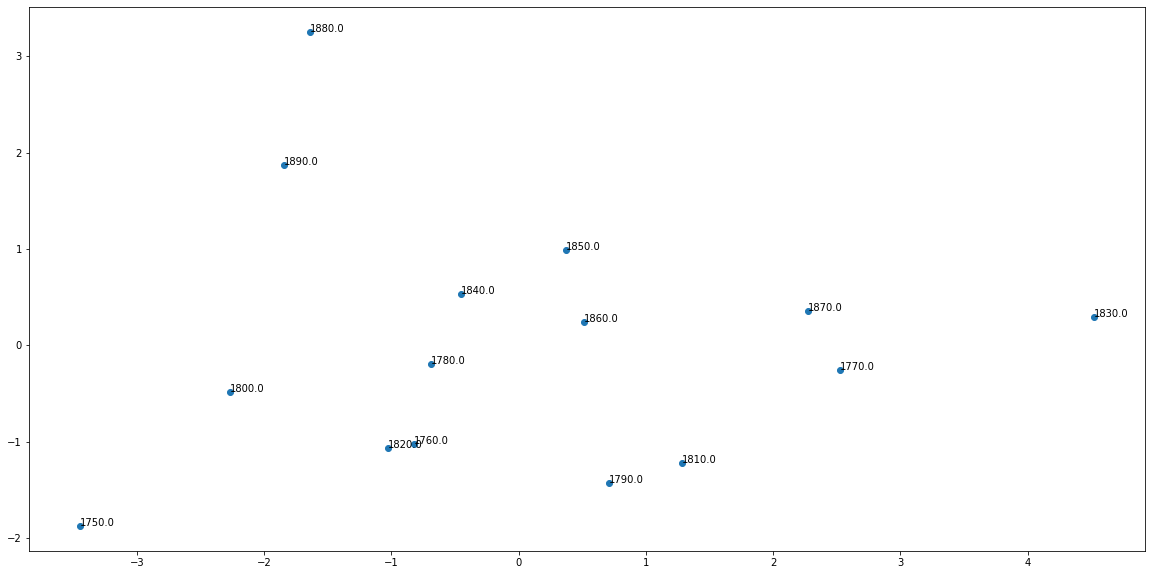

In [10]:
plt.scatter(pca_result[:,0], pca_result[:,1])
for idx, dec in enumerate(np.array(feats['decade'].unique())):
    plt.annotate(dec, (pca_result[idx, 0], pca_result[idx,1]))

In [94]:
print(pca.explained_variance_ratio_)

[0.57216721 0.23899395]
